# Brazil Deforestation, CO2 Emissions, and Fire Outbreaks Analysis

## Introduction

Welcome to our analytical project where we explore the interconnections between deforestation, CO2 emissions, and fire outbreaks in Brazil. Our aim is to determine if there's a statistical correlation between these environmental factors. Utilizing a dataset from Kaggle and the World Data Bank's wbdata python module, we've conducted a series of statistical tests to answer our research questions.

## Hypotheses

- **Null Hypothesis (H0):** Deforestation does not correlate with CO2 emissions and does not correlate with fire outbreaks.
- **Alternative Hypothesis (H1):** Deforestation correlates with CO2 emissions, fire outbreaks, or both.

## Key Findings

### Correlation between Deforestation and Fire Outbreaks
- A strong positive correlation is observed between deforestation and fire outbreaks, as indicated by the scatter plot with a linear regression line. This challenges our initial hypothesis, suggesting that as deforestation increases, so does the number of fire outbreaks.

### Correlation between Fire Outbreaks and CO2 Emissions
- The heat map and scatter plot analysis show a large negative r-value, indicating no correlation between the number of fire outbreaks and CO2 emissions. This supports our hypothesis that these two factors are not correlated.

### Correlation between Deforestation and CO2 Emissions
- Contrary to our expectations, a strong negative correlation exists between deforestation and CO2 emissions. This surprising result implies that CO2 emissions decrease as deforestation increases, prompting further investigation.

### Regional CO2 Emissions Analysis
- Bar graphs comparing CO2 emissions in Brazil and its neighboring countries over a 15-year period show an increase in emissions, suggesting regional environmental impacts that merit additional statistical examination.

## Conclusion

Our analysis leads us to reject the null hypothesis and accept the alternative hypothesis that deforestation is correlated with an increase in CO2 emissions and/or the number of fire outbreaks. This finding underscores the complexity of environmental dynamics and the need for continued research in this area.

## Acknowledgements

Data for this project was sourced from Kaggle and the World Data Bank, providing us with the necessary information to conduct our analysis.

---

*This project is a step towards understanding the intricate relationship between human activities and environmental changes. We hope that our findings contribute to the global conversation on sustainability and environmental protection.*


In [1]:
# importing our dependencies

import matplotlib.pyplot as plt
import hvplot.pandas
import pandas as pd
import wbdata as wb
import scipy.stats as st

-------------------------------------------------------------
-------------------------------------------------------------
#               DATA COLLECTION AND FORMATTING
-------------------------------------------------------------
-------------------------------------------------------------

In [2]:
# Read the CSVs into dataframes
df_a = pd.read_csv('Resources/inpe_brazilian_amazon_fires_1999_2019.csv')
df_b = pd.read_csv('Resources/def_area_2004_2019.csv')

# Create a mapping dictionary
state_mapping = {
    'AC': 'ACRE',
    'AM': 'AMAZONAS',
    'AP': 'AMAPA',
    'MA': 'MARANHAO',
    'MT': 'MATO GROSSO',
    'PA': 'PARA',
    'RO': 'RONDONIA',
    'RR': 'RORAIMA',
    'TO': 'TOCANTINS'
}

# Map the full state names in df_a to their initials
df_a['state_initials'] = df_a['state'].map({v: k for k, v in state_mapping.items()})

# Convert the 'year' column in both dataframes to the same type
df_a['year'] = df_a['year'].astype(str)
df_b['Ano/Estados'] = df_b['Ano/Estados'].astype(str)

# Melt df_b to long format to facilitate the merge
df_b_melted = pd.melt(df_b, id_vars=['Ano/Estados'], value_vars=state_mapping.keys(), 
                      var_name='state_initials', value_name='deforestation_area')

# Merge the two dataframes on the year and state initials
merged_df = pd.merge(df_a, df_b_melted, left_on=['year', 'state_initials'], right_on=['Ano/Estados', 'state_initials'], how='outer')

# Filter to keep only data from 2004 onwards
merged_df = merged_df[merged_df['year'] >= '2004']

# Drop the state initials column and the duplicate 'Ano/Estados' column
merged_df.drop(['state_initials', 'Ano/Estados'], axis=1, inplace=True)

merged_df.head()


,year,month,state,latitude,longitude,firespots,deforestation_area
455,2004,1,AMAPA,0.131862,-51.642086,58,46.0
456,2004,2,AMAPA,0.686000,-50.987000,1,46.0
457,2004,4,AMAPA,-0.930000,-52.327000,1,46.0
458,2004,5,AMAPA,-0.919000,-52.286000,1,46.0
459,2004,6,AMAPA,1.473857,-51.059571,7,46.0


In [3]:
def filter_by_state_and_year(df, state, year):
    """
    Filters the dataframe for the specified state and year.

    Parameters:
    - df (DataFrame): The dataframe to filter.
    - state (str): The state to filter by.
    - year (str): The year to filter by.

    Returns:
    - DataFrame: The filtered dataframe.
    """
    return df[(df['state'] == state) & (df['year'] == year)]

# Usage
desired_state = "ACRE"
desired_year = "2004"
filtered_df = filter_by_state_and_year(merged_df, desired_state, desired_year)
filtered_df


,year,month,state,latitude,longitude,firespots,deforestation_area
549,2004,2,ACRE,-8.150750,-72.611250,4,728.0
550,2004,4,ACRE,-10.887444,-68.537000,9,728.0
551,2004,5,ACRE,-9.346143,-70.787952,21,728.0
552,2004,6,ACRE,-9.390833,-69.686500,12,728.0
553,2004,7,ACRE,-9.350074,-68.990400,95,728.0
554,2004,8,ACRE,-9.649285,-68.874877,1003,728.0
555,2004,9,ACRE,-9.835523,-68.803959,5458,728.0
556,2004,10,ACRE,-10.121528,-68.810804,633,728.0
557,2004,11,ACRE,-9.150760,-70.571200,25,728.0
558,2004,12,ACRE,-10.345182,-68.199364,11,728.0


In [4]:
def fetch_co2_emissions(country):
    """
    Fetches the CO2 emissions per capita data for the specified country for the years 2004 to 2019.

    Parameters:
    - country (str): The name of the country to fetch the data for.

    Returns:
    - List of tuples: The CO2 emissions per capita data for the specified country for the years 2004 to 2019.
    """
    # Set the indicator ID for CO2 emissions per capita
    indicator_id = "EN.ATM.CO2E.PC"

    # Fetch the data for the specified country
    data = wb.get_data(indicator_id, country=country)

    # Filter and store the data for the years 2004 to 2019 in a list of tuples
    co2_emissions_data = []
    for country_data in data:
        date = country_data['date']
        if 2004 <= int(date) <= 2019:
            country = country_data['country']['value']
            value = country_data.get('value', None)  # Use the get method to handle missing data
            try:
                co2_emissions_data.append((float(value), date, country))
            except:
                pass
    
    return co2_emissions_data


In [5]:
# BRICS COUNTRIES DATA IF WE WANT TO USE

# country_codes = ['BRA', 'CHN', 'IND', 'RUS', 'ZAF']
# for country_code in country_codes:
#     print(fetch_co2_emissions(country_code))

In [6]:
# Brazil and neighboring countries data

country_codes = ['BRA', 'ARG', 'BOL', 'PER', 'COL', 'VEN']
for country_code in country_codes:
    print(fetch_co2_emissions(country_code))

[(2.05077012882977, '2019', 'Brazil'), (2.06426147881772, '2018', 'Brazil'), (2.18548661863967, '2017', 'Brazil'), (2.16125984748939, '2016', 'Brazil'), (2.36536062099671, '2015', 'Brazil'), (2.51459195963426, '2014', 'Brazil'), (2.4134465369818, '2013', 'Brazil'), (2.2714176835721, '2012', 'Brazil'), (2.11062775987293, '2011', 'Brazil'), (2.02660566892286, '2010', 'Brazil'), (1.79932814185315, '2009', 'Brazil'), (1.93921527398251, '2008', 'Brazil'), (1.847975735626, '2007', 'Brazil'), (1.77747795657257, '2006', 'Brazil'), (1.77566292246976, '2005', 'Brazil'), (1.77844124428615, '2004', 'Brazil')]
[(3.74202981162433, '2019', 'Argentina'), (3.97565074444479, '2018', 'Argentina'), (4.07011168693629, '2017', 'Argentina'), (4.20181586904703, '2016', 'Argentina'), (4.30191380564475, '2015', 'Argentina'), (4.20911189491323, '2014', 'Argentina'), (4.34225013023383, '2013', 'Argentina'), (4.26411100150765, '2012', 'Argentina'), (4.28102814513, '2011', 'Argentina'), (4.09984413971278, '2010', '

In [7]:
# Create an empty dataframe with the desired column names
co2_emissions_df = pd.DataFrame(columns=['CO2 Emissions', 'Year', 'Country'])

# Loop through the country codes and append the output of fetch_co2_emissions() to the dataframe
for country_code in country_codes:
    co2_emissions_data = fetch_co2_emissions(country_code)
    for data in co2_emissions_data:
        co2_emissions_df = pd.concat([co2_emissions_df, pd.DataFrame({'CO2 Emissions': [data[0]], 'Year': [data[1]], 'Country': [data[2]]})], ignore_index=True)

# Pivot the dataframe to have the countries as columns
co2_emissions_pivoted = co2_emissions_df.pivot(index='Year', columns='Country', values='CO2 Emissions')

co2_emissions_pivoted

Country,Argentina,Bolivia,Brazil,Colombia,Peru,"Venezuela, RB"
Year,,,,,,
2004,3.656085,1.018025,1.778441,1.359214,1.119854,5.323029
2005,3.736717,1.053918,1.775663,1.378155,1.111717,5.526101
2006,3.924262,1.122842,1.777478,1.360511,1.086770,5.443571
2007,4.083151,1.226168,1.847976,1.378772,1.182096,5.173046
2008,4.152375,1.288809,1.939215,1.376188,1.329319,5.409644
2009,3.848348,1.350112,1.799328,1.414242,1.419219,5.386433
2010,4.099844,1.438111,2.026606,1.431318,1.539485,5.714835
2011,4.281028,1.538219,2.110628,1.539898,1.642847,5.500369
2012,4.264111,1.604682,2.271418,1.533846,1.617522,6.146121


-------------------------
-------------------------
#  DATA VISUALIZATIONS
-------------------------
-------------------------

SCATTER PLOTS
--------------------------

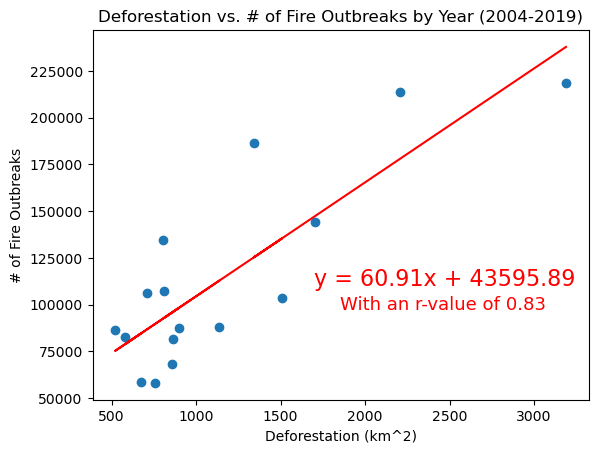

In [8]:
#-------------------------------------------------------------
#              DEFORESTATION VS. FIRE OUTBREAKS
#-------------------------------------------------------------

# Defining our comparison values

# Adding up the firespots for the year
outbreaks_sum = merged_df.groupby('year')['firespots'].sum()
# Finding the mean deforestation area for the year
deforestation_mean = merged_df.groupby('year')['deforestation_area'].mean()

# Finding values for our linear regression and the resulting fit
slope, intercept, rvalue, pvalue, stderr = st.linregress(deforestation_mean,outbreaks_sum)
fit = slope * deforestation_mean + intercept

# Creating annotated information
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
r_value = f'With an r-value of {round(st.pearsonr(deforestation_mean, outbreaks_sum)[0], 2)}'

# Plotting and formatting our comparison data
plt.scatter(deforestation_mean, outbreaks_sum)
plt.xlabel('Deforestation (km^2)')
plt.ylabel('# of Fire Outbreaks')
plt.title('Deforestation vs. # of Fire Outbreaks by Year (2004-2019)')
plt.plot(deforestation_mean, fit, '-', color='r')
plt.annotate(line_eq, (1700, 110000), color = 'r', fontsize = 16)
plt.annotate(r_value, (1850, 97500), color = 'r', fontsize = 13)
plt.savefig('Visualizations/deforest_outbreaks.png')

plt.show()


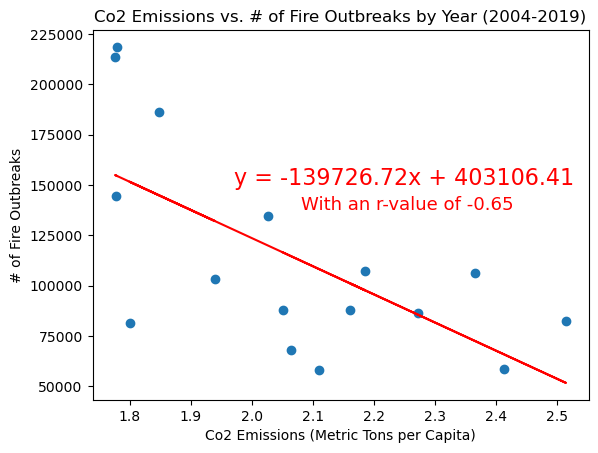

In [9]:
#-------------------------------------------------------------
#              CO2 EMISSIONS VS FIRE OUTBREAKS
#-------------------------------------------------------------

# Defining our comparison values
emissions_mean = co2_emissions_pivoted['Brazil']

# Finding values for our linear regression and the resulting fit
slope, intercept, rvalue, pvalue, stderr = st.linregress(emissions_mean,outbreaks_sum)
fit = slope * emissions_mean + intercept

# Creating annotated information
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
r_value = f'With an r-value of {round(st.pearsonr(emissions_mean, outbreaks_sum)[0], 2)}'

# Plotting and formatting our comparison data
plt.scatter(emissions_mean, outbreaks_sum)
plt.xlabel('Co2 Emissions (Metric Tons per Capita)')
plt.ylabel('# of Fire Outbreaks')
plt.title('Co2 Emissions vs. # of Fire Outbreaks by Year (2004-2019)')
plt.plot(emissions_mean, fit, '-', color='r')
plt.annotate(line_eq, (1.97, 150000), color = 'r', fontsize = 16)
plt.annotate(r_value, (2.08, 137500), color = 'r', fontsize = 13)
plt.savefig('Visualizations/emissions_outbreaks.png')

plt.show()


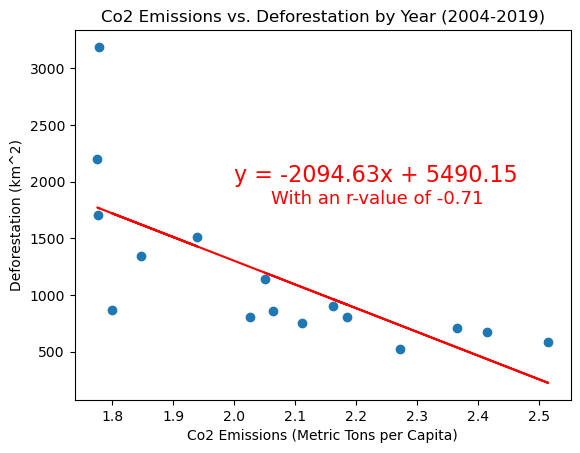

In [10]:
#-------------------------------------------------------------
#              CO2 EMISSIONS VS DEFORESTATION
#-------------------------------------------------------------

# Finding values for our linear regression and the resulting fit
slope, intercept, rvalue, pvalue, stderr = st.linregress(emissions_mean,deforestation_mean)
fit = slope * emissions_mean + intercept

# Creating annotated information
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
r_value = f'With an r-value of {round(st.pearsonr(emissions_mean, deforestation_mean)[0], 2)}'

# Plotting and formatting our comparison data
plt.scatter(emissions_mean, deforestation_mean)
plt.xlabel('Co2 Emissions (Metric Tons per Capita)')
plt.ylabel('Deforestation (km^2)')
plt.title('Co2 Emissions vs. Deforestation by Year (2004-2019)')
plt.plot(emissions_mean, fit, '-', color='r')
plt.annotate(line_eq, (2.0, 2000), color = 'r', fontsize = 16)
plt.annotate(r_value, (2.06, 1800), color = 'r', fontsize = 13)
plt.savefig('Visualizations/emissions_deforest.png')

plt.show()


MISCELLANEOUS PLOTS
--------------------

In [11]:
#-------------------------------------------------------------
#              FIRE OUTBREAKS VISUALIZED
#-------------------------------------------------------------

fire_outbreak_plot = merged_df.hvplot.points('longitude',
                             'latitude',
                             geo=True,
                             color='r',
                             hover_cols = ['state', 'deforestation_area'],
                             frame_width = 800,
                             frame_height = 800, 
                             size ='firespots',
                             tiles='EsriNatGeo',
                             scale=0.1,
                             title='Fire Outbreaks Within Brazil',
                             xlabel='Longitude',
                             ylabel='Latitude',
                             alpha=0.5)

fire_outbreak_plot

c:\Users\ocean\anaconda3\envs\dev\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (firespots,state,deforestation_area)

In [12]:
# ------------------------
# INFO FOR MULTI-LINE PLOT
# ------------------------

# STATE DEFORESTATION VALUES

amapa_deforestation = merged_df.loc[merged_df['state'] == 'AMAPA'].groupby('year')['deforestation_area'].mean()
amazonas_deforestation = merged_df.loc[merged_df['state'] == 'AMAZONAS'].groupby('year')['deforestation_area'].mean()
maranhao_deforestation = merged_df.loc[merged_df['state'] == 'MARANHAO'].groupby('year')['deforestation_area'].mean()
mato_grosso_deforestation = merged_df.loc[merged_df['state'] == 'MATO GROSSO'].groupby('year')['deforestation_area'].mean()
para_deforestation = merged_df.loc[merged_df['state'] == 'PARA'].groupby('year')['deforestation_area'].mean()
rondonia_deforestation = merged_df.loc[merged_df['state'] == 'RONDONIA'].groupby('year')['deforestation_area'].mean()
roraima_deforestation = merged_df.loc[merged_df['state'] == 'RORAIMA'].groupby('year')['deforestation_area'].mean()
tocantins_deforestation = merged_df.loc[merged_df['state'] == 'TOCANTINS'].groupby('year')['deforestation_area'].mean()
acre_deforestation = merged_df.loc[merged_df['state'] == 'ACRE'].groupby('year')['deforestation_area'].mean()

years = merged_df['year'].unique()


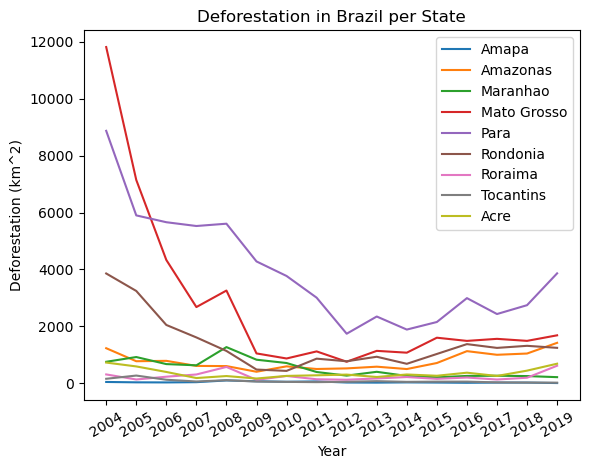

In [13]:
#-------------------------------------------------------------
#                 DEFORESTATION BY STATE
#-------------------------------------------------------------

plt.plot(years, amapa_deforestation,label = 'Amapa')
plt.plot(years,amazonas_deforestation,label = 'Amazonas')
plt.plot(years,maranhao_deforestation,label='Maranhao')
plt.plot(years,mato_grosso_deforestation,label='Mato Grosso')
plt.plot(years,para_deforestation,label='Para')
plt.plot(years,rondonia_deforestation,label='Rondonia')
plt.plot(years,roraima_deforestation,label='Roraima')
plt.plot(years,tocantins_deforestation,label='Tocantins')
plt.plot(years,acre_deforestation,label='Acre')

plt.xticks(rotation=30)
plt.xlabel('Year')
plt.ylabel('Deforestation (km^2)')
plt.title('Deforestation in Brazil per State')
plt.legend()
plt.savefig('Visualizations/deforest_by_state.png')

plt.show()

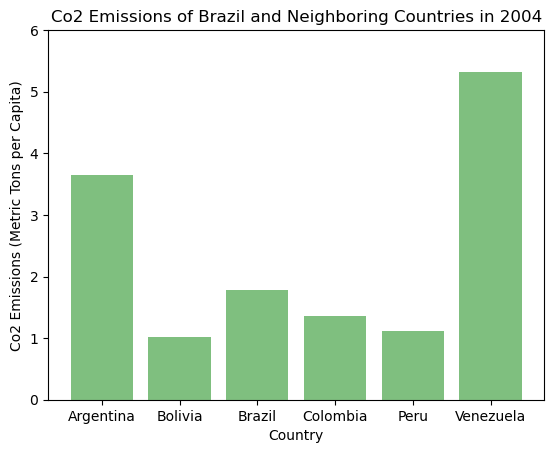

In [14]:
#-------------------------------------------------------------
#        CO2 EMISSIONS AT START AND END OF OUR DATASET
#-------------------------------------------------------------

countries = ['Argentina', 'Bolivia', 'Brazil', 'Colombia', 'Peru', 'Venezuela']

emissions_2004 = co2_emissions_pivoted.loc[co2_emissions_pivoted.index[0]]
emissions_2019 = co2_emissions_pivoted.loc[co2_emissions_pivoted.index[15]]

plt.bar(countries,emissions_2004, alpha = 0.5, color = 'g')
plt.xlabel('Country')
plt.ylabel('Co2 Emissions (Metric Tons per Capita)')
plt.title('Co2 Emissions of Brazil and Neighboring Countries in 2004')
plt.ylim(0, 6)
plt.savefig('Visualizations/2004_emissions_w_neighboring_countries.png')


plt.show()

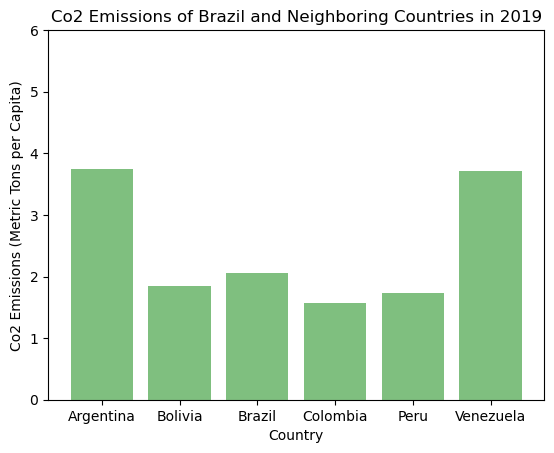

In [15]:
plt.bar(countries, emissions_2019, alpha = 0.5, color = 'g')
plt.xlabel('Country')
plt.ylabel('Co2 Emissions (Metric Tons per Capita)')
plt.title('Co2 Emissions of Brazil and Neighboring Countries in 2019')
plt.ylim(0,6)
plt.savefig('Visualizations/2019_emissions_w_neighboring_countries.png')

plt.show()